In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.stats import chi2

In [ ]:
audio_file = 'sample-000003.mp3'  # Replace with your audio file path

In [3]:
def load_audio(file_path, sr=16000):
    signal, sample_rate = librosa.load(file_path, sr=sr)
    return signal, sample_rate

In [4]:
def add_white_noise(signal, snr_db):
    # Calculate the power of the original signal
    signal_power = np.mean(signal**2)

    # Calculate the power of the noise required for the desired SNR
    snr_linear = 10**(snr_db / 10)
    noise_power = signal_power / snr_linear

    # Generate white noise with the calculated power
    noise = np.random.normal(0, np.sqrt(noise_power), signal.shape)

    noisy_signal = signal + noise
    return noisy_signal

In [5]:
# Estimate noise statistics (assume initial frames are noise)
def estimate_noise_initial(signal, frame_length=512, hop_length=256, noise_frames=5):
    stft = librosa.stft(signal, n_fft=frame_length, hop_length=hop_length)
    magnitude_spectrogram = np.abs(stft) ** 2
    noise_estimate = np.mean(magnitude_spectrogram[:, :noise_frames], axis=1)
    return noise_estimate

In [6]:
# Calculate the threshold
def calculate_threshold(noise_variance, P_FA=0.1):
    threshold = np.sqrt(2 * noise_variance * np.log(1 / P_FA))
    return threshold

In [7]:
def vad_nosmoothing(signal, threshold, frame_length=512, hop_length=256, forgetting_factor = 0.8):
    stft = librosa.stft(signal, n_fft=frame_length, hop_length=hop_length)
    magnitude_spectrogram = np.abs(stft)

    # Calculate the test statistic by averaging over frequency bins (axis=0)
    test_statistic = np.mean(magnitude_spectrogram, axis=0)
    threshold = np.mean(threshold, axis = 0)
    # Apply the threshold to get the VAD mask
    vad_mask = test_statistic > threshold
    return vad_mask

In [8]:
def plot_vad(signal, vad_mask, hop_length=256, sr=16000):
    time = np.arange(len(signal)) / sr
    frame_time = np.arange(len(vad_mask)) * hop_length / sr
    plt.figure(figsize=(14, 6))
    plt.plot(time, signal, label='Signal')
    plt.plot(frame_time, vad_mask * np.max(signal), label='VAD Output', color='r', linestyle='--')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Voice Activity Detection')
    plt.legend()
    plt.show()

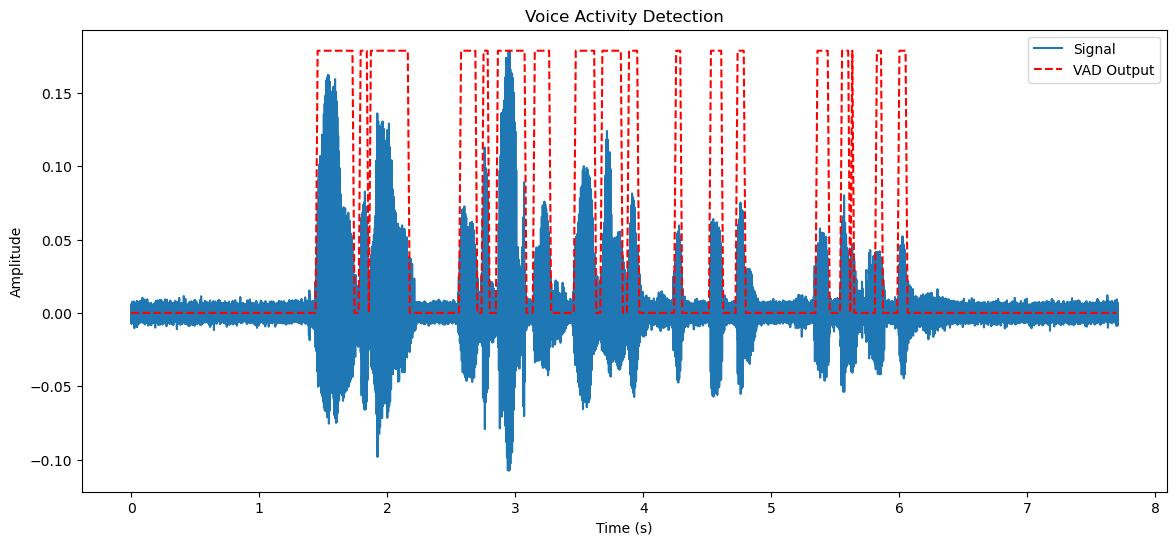

In [12]:
# Detect voice with no smoothing
snr_db = 15
signal, sr = load_audio(audio_file)
signal = add_white_noise(signal, snr_db)
noise_variance = estimate_noise_initial(signal)
threshold = calculate_threshold(noise_variance)
vad_mask = vad_nosmoothing(signal, threshold)
plot_vad(signal, vad_mask, sr=sr)

In [ ]:
# Add forgetting factor 

In [17]:
# Compute periodogram
def compute_periodogram(signal, frame_length, hop_length,):
    stft = librosa.stft(signal, n_fft=frame_length, hop_length=hop_length, window='hann')
    periodogram = np.abs(stft) ** 2
    return periodogram

# Recursive smoothed periodogram
def smoothed_periodogram(periodogram, alpha):
    smoothed_psd = np.zeros_like(periodogram)
    smoothed_psd[:, 0] = periodogram[:, 0]
    for t in range(1, periodogram.shape[1]):
        smoothed_psd[:, t] = alpha * smoothed_psd[:, t-1] + (1 - alpha) * periodogram[:, t]
    return smoothed_psd

# Minimum statistics
def minimum_statistics(psd, window_length):
    noise_estimate = np.zeros_like(psd)
    for f in range(psd.shape[0]):
        for t in range(psd.shape[1]):
            if t < window_length:
                noise_estimate[f, t] = np.min(psd[f, :t+1])
            else:
                noise_estimate[f, t] = np.min(psd[f, t-window_length:t+1])
    return noise_estimate

# Step 5: Noise estimation
def noise_estimation_minimum_statistics(signal, frame_length, hop_length, alpha, min_stat_window):
    periodogram = compute_periodogram(signal, frame_length, hop_length)
    smoothed_psd =  smoothed_periodogram(periodogram, alpha)
    noise_psd_estimate = minimum_statistics(smoothed_psd, min_stat_window)
    return noise_psd_estimate

In [18]:
# VAD function with magnitude and threshold smoothed
def vad_bothsmoothing(signal, threshold, frame_length=512, hop_length=256, forgetting_factor_mag=0.9, forgetting_factor_thres=0.2):
    periodogram = compute_periodogram(signal, frame_length, hop_length)
    magnitude_spectrogram = np.sqrt(periodogram)
    n_columns = magnitude_spectrogram.shape[1]

    for i in range(1, n_columns):
        magnitude_spectrogram[:, i] = (magnitude_spectrogram[:, i] * (1-forgetting_factor_mag) + magnitude_spectrogram[:, i - 1] * forgetting_factor_mag)
        threshold[i] = (threshold[i] * (1- forgetting_factor_thres) + threshold[i - 1] * forgetting_factor_thres)

    test_statistic = np.mean(magnitude_spectrogram, axis=0)
    vad_mask = test_statistic > threshold
    return vad_mask

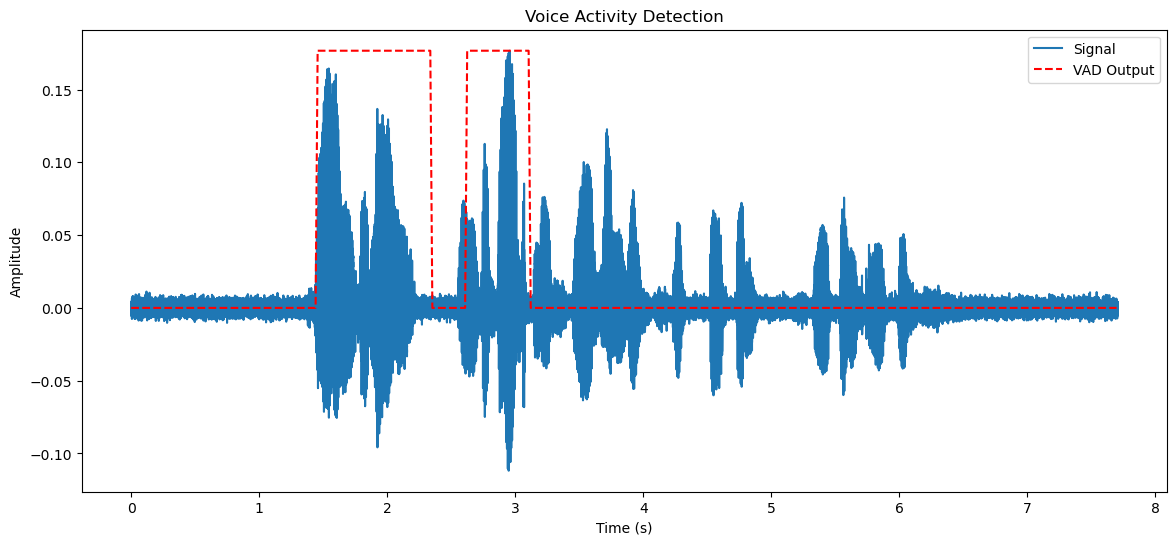

In [19]:
snr_db = 15
frame_length = 512
hop_length = 256
alpha = 0.85
min_stat_window = 96

signal, sr = load_audio(audio_file)
signal = add_white_noise(signal, snr_db)
noise_psd_estimate = noise_estimation_minimum_statistics(signal, frame_length, hop_length, alpha, min_stat_window)
noise_variance = np.mean(noise_psd_estimate, axis=0)
threshold = calculate_threshold(noise_variance)
vad_mask = vad_bothsmoothing(signal, threshold, frame_length, hop_length)
plot_vad(signal, vad_mask, hop_length, sr=sr)